In [1]:
import mpramnist
from mpramnist.Sure.dataset import SureDataset

from mpramnist.models import HumanLegNet
from mpramnist.models import initialize_weights
from mpramnist.trainers import LitModel_Sure_Clas, LitModel_Sure_Reg

from mpramnist import transforms as t
from mpramnist import target_transforms as t_t

import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning.pytorch as L
import torch.utils.data as data
from lightning.pytorch.callbacks import ModelCheckpoint

from torchmetrics import PearsonCorrCoef

from torch.nn.utils.rnn import pad_sequence

In [2]:
BATCH_SIZE = 96
NUM_WORKERS = 103

In [3]:
# preprocessing
train_transform = t.Compose([
    t.ReverseComplement(0.5),
    t.Seq2Tensor(),
])
test_transform = t.Compose([
    t.Seq2Tensor(), 
])

def pad_collate(batch): #required, because length of sequences is different
    (seq, targets) = zip(*batch)

    seq = pad_sequence(seq, batch_first=True, padding_value=0.25)

    return seq, torch.vstack(targets)

In [4]:
GENOME_IDS = SureDataset.GENOME_IDS
GENOME_IDS

['SuRE42_HG02601', 'SuRE43_GM18983', 'SuRE44_HG01241', 'SuRE45_HG03464']

In [5]:
CELL_TYPES = SureDataset.CELL_TYPES
CELL_TYPES

['K562', 'HepG2']

In [6]:
forw_transform = t.Compose([
    t.Seq2Tensor()
])
rev_transform = t.Compose([
    t.ReverseComplement(1),
    t.Seq2Tensor(),
])

def meaned_prediction(forw, rev, trainer, seq_model, name):

    predictions_forw = trainer.predict(seq_model, dataloaders = forw)
    targets = torch.cat([pred["target"] for pred in predictions_forw])
    y_preds_forw = torch.cat([pred["predicted"] for pred in predictions_forw])
    
    predictions_rev = trainer.predict(seq_model, dataloaders = rev)
    y_preds_rev = torch.cat([pred["predicted"] for pred in predictions_rev])
    
    mean_forw = torch.mean(torch.stack([y_preds_forw, y_preds_rev]), dim=0)
    
    pears = PearsonCorrCoef(num_outputs = 2)
    print(name + " Pearson correlation")
    
    return pears(mean_forw, targets)

# Classification

In [7]:
task = "classification"

# load the data
train_dataset = SureDataset(task = task, genome_id = GENOME_IDS[0], 
                            split="train", transform=train_transform, root = "../data/")  # for needed folds
val_dataset = SureDataset(task = task, genome_id = GENOME_IDS[0], 
                          split="val", transform=test_transform, root = "../data/") # use "val" for default validation set
test_dataset = SureDataset(task = task, genome_id = GENOME_IDS[0], 
                           split="test", transform=test_transform, root = "../data/") # use "test" for default test set

In [8]:
print(train_dataset)
print(50*"-")
print(val_dataset)
print(25*"-")
print(test_dataset)
print(50*"-")

Dataset SureDataset of size 619051 (MpraDaraset)
    Number of datapoints: 619051
    Used split fold: train
--------------------------------------------------
Dataset SureDataset of size 73935 (MpraDaraset)
    Number of datapoints: 73935
    Used split fold: val
-------------------------
Dataset SureDataset of size 73947 (MpraDaraset)
    Number of datapoints: 73947
    Used split fold: test
--------------------------------------------------


In [9]:
N_CLASSES = train_dataset.num_outputs
in_channels = len(train_dataset[0][0][0])

In [10]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

val_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

In [11]:
model = HumanLegNet(in_ch=in_channels,
                     output_dim = N_CLASSES,
                     stem_ch=64,
                     stem_ks=11,
                     ef_ks=9,
                     ef_block_sizes=[80, 96, 112, 128],
                     pool_sizes=[2,2,2,2],
                     resize_factor=4)
model.apply(initialize_weights)

seq_model = LitModel_Sure_Clas(model = model,
                           loss = nn.CrossEntropyLoss(),
                           n_classes = N_CLASSES,
                           weight_decay = 1e-2, lr = 5e-3, print_each = 10)

In [12]:
checkpoint_callback = ModelCheckpoint(
        monitor='val_loss', 
        mode='min',  
        save_top_k=1,
        save_last=False
    )
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=50,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0,
    callbacks=[checkpoint_callback]
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [13]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders = train_loader,
            val_dataloaders = val_loader)     

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | HumanLegNet      | 1.3 M  | train
1 | loss          | CrossEntropyLoss | 0      | train
2 | train_pearson | PearsonCorrCoef  | 0      | train
3 | val_pearson   | PearsonCorrCoef  | 0      | train
4 | test_pearson  | PearsonCorrCoef  | 0      | train
-----------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


| Current_epoch: 9.00000 |


----------------------------------------------------------------------------------------------------
| K562: || Precision: 0.34565 | Recall: 0.33303 | Accuracy: 0.33473 | F1: 0.28319 | Val_AUCROC: 0.68716 | Val_AUPR: 0.34037 |
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
| HepG2: || Precision: 0.31573 | Recall: 0.31651 | Accuracy: 0.31942 | F1: 0.26571 | Val_AUCROC: 0.64967 | Val_AUPR: 0.30704 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


| Current_epoch: 19.00000 |


----------------------------------------------------------------------------------------------------
| K562: || Precision: 0.34915 | Recall: 0.34696 | Accuracy: 0.34791 | F1: 0.31096 | Val_AUCROC: 0.69585 | Val_AUPR: 0.34512 |
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
| HepG2: || Precision: 0.30245 | Recall: 0.32092 | Accuracy: 0.32376 | F1: 0.25932 | Val_AUCROC: 0.65339 | Val_AUPR: 0.30852 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


| Current_epoch: 29.00000 |


----------------------------------------------------------------------------------------------------
| K562: || Precision: 0.36971 | Recall: 0.34467 | Accuracy: 0.34679 | F1: 0.31648 | Val_AUCROC: 0.69897 | Val_AUPR: 0.34891 |
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
| HepG2: || Precision: 0.31403 | Recall: 0.33228 | Accuracy: 0.33509 | F1: 0.28323 | Val_AUCROC: 0.65986 | Val_AUPR: 0.31456 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


| Current_epoch: 39.00000 |


----------------------------------------------------------------------------------------------------
| K562: || Precision: 0.36644 | Recall: 0.35167 | Accuracy: 0.35351 | F1: 0.31681 | Val_AUCROC: 0.69899 | Val_AUPR: 0.35186 |
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
| HepG2: || Precision: 0.31130 | Recall: 0.33546 | Accuracy: 0.33794 | F1: 0.29560 | Val_AUCROC: 0.65859 | Val_AUPR: 0.31610 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


| Current_epoch: 49.00000 |


----------------------------------------------------------------------------------------------------
| K562: || Precision: 0.35372 | Recall: 0.35058 | Accuracy: 0.35166 | F1: 0.32923 | Val_AUCROC: 0.68718 | Val_AUPR: 0.34149 |
----------------------------------------------------------------------------------------------------



`Trainer.fit` stopped: `max_epochs=50` reached.



----------------------------------------------------------------------------------------------------
| HepG2: || Precision: 0.30615 | Recall: 0.32323 | Accuracy: 0.32567 | F1: 0.29377 | Val_AUCROC: 0.64132 | Val_AUPR: 0.30053 |
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| K562: || Precision: 0.34806 | Recall: 0.35151 | Accuracy: 0.35283 | F1: 0.30991 | Val_AUCROC: 0.69917 | Val_AUPR: 0.35120 |
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
| HepG2: || Precision: 0.32108 | Recall: 0.33531 | Accuracy: 0.33823 | F1: 0.28818 | Val_AUCROC: 0.66296 | Val_AUPR: 0.31898 |
----------------------------------------------------------------------------------------------------



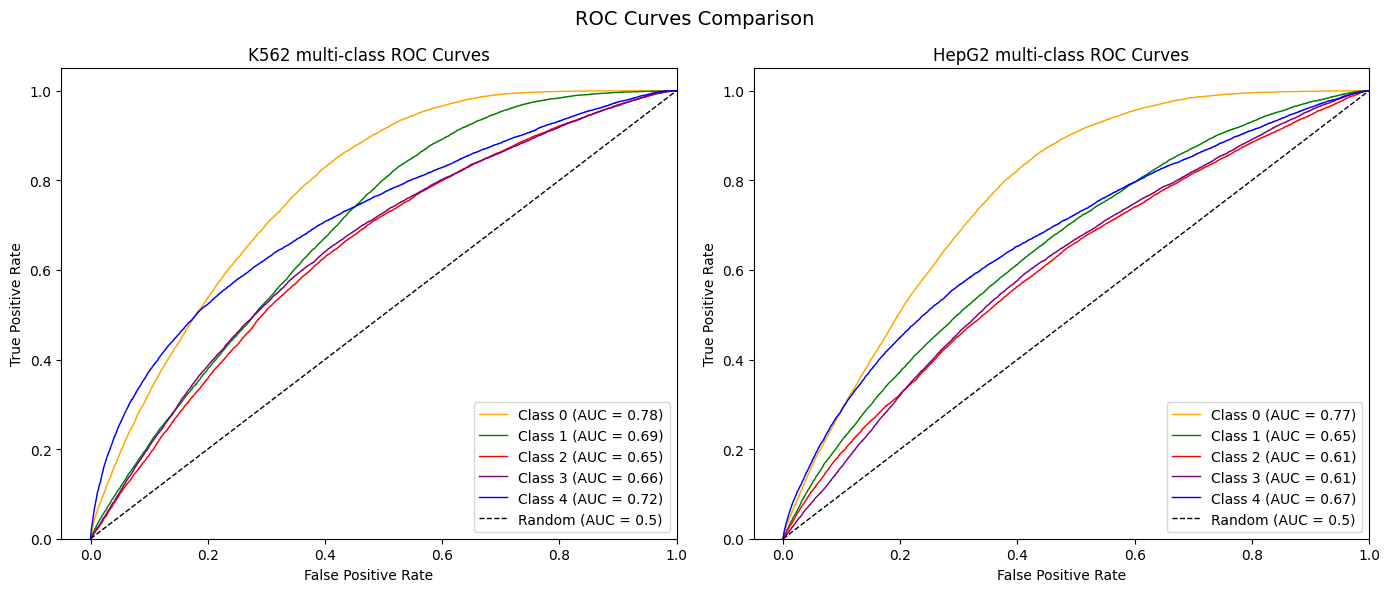

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.9231839179992676
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.9231839179992676}]

In [14]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_Sure_Clas.load_from_checkpoint(
    best_model_path,
    model=model,
    loss = nn.CrossEntropyLoss(),
    n_classes = N_CLASSES,
   weight_decay = 1e-2, lr = 5e-3, print_each = 1
)
trainer.test(seq_model, dataloaders = test_loader)

# Regression

In [15]:
task = "regression"

GENOME_IDS = SureDataset.GENOME_IDS
CELL_TYPES = SureDataset.CELL_TYPES

## SuRE42_HG02601

In [16]:
SureDataset.GENOME_IDS[0]

'SuRE42_HG02601'

In [17]:
train_dataset = SureDataset(task = task, genome_id = GENOME_IDS[0],
                            split="train", transform=train_transform, root = "../data/")  # for needed folds

val_dataset = SureDataset(task = task, genome_id = GENOME_IDS[0],
                          split="val", transform=test_transform, root = "../data/") # use "val" for default validation set

test_dataset = SureDataset(task = task, genome_id = GENOME_IDS[0],
                           split="test", transform=test_transform, root = "../data/") # use "test" for default test set

In [18]:
num_outputs = train_dataset.num_outputs
in_channels = len(train_dataset[0][0][0])

In [19]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

In [20]:
model = HumanLegNet(in_ch=in_channels,
                     output_dim = num_outputs,
                     stem_ch=64,
                     stem_ks=11,
                     ef_ks=9,
                     ef_block_sizes=[80, 96, 112, 128],
                     pool_sizes=[2,2,2,2],
                     resize_factor=4)
model.apply(initialize_weights)

seq_model = LitModel_Sure_Reg(model = model,
                           loss = nn.MSELoss(),
                           num_outputs = num_outputs,
                           weight_decay = 1e-2, lr = 5e-3, print_each = 25)

In [21]:
checkpoint_callback = ModelCheckpoint(
        monitor='val_pearson', 
        mode='max',  
        save_top_k=1,
        save_last=False
    )
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=50,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0,
    enable_model_summary=False,
    callbacks=[checkpoint_callback]
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [22]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders = train_loader,
            val_dataloaders = val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


--------------------------------------------------------------------------------------------------------------------
| Epoch: 24 | Val Loss: 463.95331 | Val Pearson K562: 0.46857 | Val Pearson HepG2: 0.32948 | Train Pearson: 0.42455 
--------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=50` reached.



--------------------------------------------------------------------------------------------------------------------
| Epoch: 49 | Val Loss: 479.09180 | Val Pearson K562: 0.48341 | Val Pearson HepG2: 0.28342 | Train Pearson: 0.61038 
--------------------------------------------------------------------------------------------------------------------



In [23]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_Sure_Reg.load_from_checkpoint(
    best_model_path,
    model=model,
    loss = nn.MSELoss(),
    n_classes = N_CLASSES,
    weight_decay = 1e-2, lr = 5e-3, print_each = 1
)
trainer.test(seq_model, dataloaders = test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss              467.541015625
   test_pearson HepG2       0.34863269329071045
    test_pearson K562       0.5060179829597473
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 467.541015625,
  'test_pearson K562': 0.5060179829597473,
  'test_pearson HepG2': 0.34863269329071045}]

In [24]:
test_forw = SureDataset(task = task, genome_id = GENOME_IDS[0], split = "test", transform = forw_transform, root = "../data/")
test_rev = SureDataset(task = task, genome_id = GENOME_IDS[0], split = "test", transform = rev_transform, root = "../data/")

forw = data.DataLoader(dataset=test_forw, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)
rev = data.DataLoader(dataset=test_rev, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

meaned_prediction(forw, rev, trainer, seq_model, GENOME_IDS[0])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

SuRE42_HG02601 Pearson correlation


tensor([0.5115, 0.3579])

## SuRE43_GM18983

In [25]:
GENOME_IDS[1]

'SuRE43_GM18983'

In [26]:
train_dataset = SureDataset(task = task, genome_id = GENOME_IDS[1],
                            split="train", transform=train_transform, root = "../data/")  # for needed folds

val_dataset = SureDataset(task = task, genome_id = GENOME_IDS[1],
                          split="val", transform=test_transform, root = "../data/") # use "val" for default validation set

test_dataset = SureDataset(task = task, genome_id = GENOME_IDS[1],
                           split="test", transform=test_transform, root = "../data/") # use "test" for default test set

In [27]:
num_outputs = train_dataset.num_outputs
in_channels = len(train_dataset[0][0][0])

In [28]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

In [29]:
model = HumanLegNet(in_ch=in_channels,
                     output_dim = num_outputs,
                     stem_ch=64,
                     stem_ks=11,
                     ef_ks=9,
                     ef_block_sizes=[80, 96, 112, 128],
                     pool_sizes=[2,2,2,2],
                     resize_factor=4)
model.apply(initialize_weights)

seq_model = LitModel_Sure_Reg(model = model,
                           loss = nn.MSELoss(),
                           num_outputs = num_outputs,
                           weight_decay = 1e-2, lr = 5e-3, print_each = 25)

In [30]:
checkpoint_callback = ModelCheckpoint(
        monitor='val_pearson', 
        mode='max',  
        save_top_k=1,
        save_last=False
    )
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=50,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0,
    enable_model_summary=False,
    callbacks=[checkpoint_callback]
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [31]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders = train_loader,
            val_dataloaders = val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


--------------------------------------------------------------------------------------------------------------------
| Epoch: 24 | Val Loss: 568.08746 | Val Pearson K562: 0.42079 | Val Pearson HepG2: 0.32207 | Train Pearson: 0.46512 
--------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=50` reached.



--------------------------------------------------------------------------------------------------------------------
| Epoch: 49 | Val Loss: 575.80719 | Val Pearson K562: 0.43309 | Val Pearson HepG2: 0.29495 | Train Pearson: 0.65403 
--------------------------------------------------------------------------------------------------------------------



In [32]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_Sure_Reg.load_from_checkpoint(
    best_model_path,
    model=model,
    loss = nn.MSELoss(),
    n_classes = N_CLASSES,
    weight_decay = 1e-2, lr = 5e-3, print_each = 1
)
trainer.test(seq_model, dataloaders = test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            497.2357177734375
   test_pearson HepG2       0.33736005425453186
    test_pearson K562       0.48918408155441284
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 497.2357177734375,
  'test_pearson K562': 0.48918408155441284,
  'test_pearson HepG2': 0.33736005425453186}]

In [33]:
test_forw = SureDataset(task = task, genome_id = GENOME_IDS[1], split = "test", transform = forw_transform, root = "../data/")
test_rev = SureDataset(task = task, genome_id = GENOME_IDS[1], split = "test", transform = rev_transform, root = "../data/")

forw = data.DataLoader(dataset=test_forw, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)
rev = data.DataLoader(dataset=test_rev, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

meaned_prediction(forw, rev, trainer, seq_model, GENOME_IDS[1])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

SuRE43_GM18983 Pearson correlation


tensor([0.4973, 0.3436])

## SuRE44_HG01241

In [34]:
GENOME_IDS[2]

'SuRE44_HG01241'

In [35]:
train_dataset = SureDataset(task = task, genome_id = GENOME_IDS[2],
                            split="train", transform=train_transform, root = "../data/")  # for needed folds

val_dataset = SureDataset(task = task, genome_id = GENOME_IDS[2],
                          split="val", transform=test_transform, root = "../data/") # use "val" for default validation set

test_dataset = SureDataset(task = task, genome_id = GENOME_IDS[2],
                           split="test", transform=test_transform, root = "../data/") # use "test" for default test set

In [36]:
num_outputs = train_dataset.num_outputs
in_channels = len(train_dataset[0][0][0])

In [37]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

In [38]:
model = HumanLegNet(in_ch=in_channels,
                     output_dim = num_outputs,
                     stem_ch=64,
                     stem_ks=11,
                     ef_ks=9,
                     ef_block_sizes=[80, 96, 112, 128],
                     pool_sizes=[2,2,2,2],
                     resize_factor=4)
model.apply(initialize_weights)

seq_model = LitModel_Sure_Reg(model = model,
                           loss = nn.MSELoss(),
                           num_outputs = num_outputs,
                           weight_decay = 1e-2, lr = 5e-3, print_each = 25)

In [39]:
checkpoint_callback = ModelCheckpoint(
        monitor='val_pearson', 
        mode='max',  
        save_top_k=1,
        save_last=False
    )
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=50,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0,
    enable_model_summary=False,
    callbacks=[checkpoint_callback]
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders = train_loader,
            val_dataloaders = val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                       | 0/? [00:00…

In [ ]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_Sure_Reg.load_from_checkpoint(
    best_model_path,
    model=model,
    loss = nn.MSELoss(),
    n_classes = N_CLASSES,
    weight_decay = 1e-2, lr = 5e-3, print_each = 1
)
trainer.test(seq_model, dataloaders = test_loader)

In [ ]:
test_forw = SureDataset(task = task, genome_id = GENOME_IDS[2], split = "test", transform = forw_transform, root = "../data/")
test_rev = SureDataset(task = task, genome_id = GENOME_IDS[2], split = "test", transform = rev_transform, root = "../data/")

forw = data.DataLoader(dataset=test_forw, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)
rev = data.DataLoader(dataset=test_rev, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

meaned_prediction(forw, rev, trainer, seq_model, GENOME_IDS[2])

## SuRE45_HG03464

In [ ]:
GENOME_IDS[3]

In [ ]:
train_dataset = SureDataset(task = task, genome_id = GENOME_IDS[3],
                            split="train", transform=train_transform, root = "../data/")  # for needed folds

val_dataset = SureDataset(task = task, genome_id = GENOME_IDS[3],
                          split="val", transform=test_transform, root = "../data/") # use "val" for default validation set

test_dataset = SureDataset(task = task, genome_id = GENOME_IDS[3],
                           split="test", transform=test_transform, root = "../data/") # use "test" for default test set

In [ ]:
num_outputs = train_dataset.num_outputs
in_channels = len(train_dataset[0][0][0])

In [ ]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

In [ ]:
model = HumanLegNet(in_ch=in_channels,
                     output_dim = num_outputs,
                     stem_ch=64,
                     stem_ks=11,
                     ef_ks=9,
                     ef_block_sizes=[80, 96, 112, 128],
                     pool_sizes=[2,2,2,2],
                     resize_factor=4)
model.apply(initialize_weights)

seq_model = LitModel_Sure_Reg(model = model,
                           loss = nn.MSELoss(),
                           num_outputs = num_outputs,
                           weight_decay = 1e-2, lr = 5e-3, print_each = 25)

In [ ]:
checkpoint_callback = ModelCheckpoint(
        monitor='val_pearson', 
        mode='max',  
        save_top_k=1,
        save_last=False
    )
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=50,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0,
    enable_model_summary=False,
    callbacks=[checkpoint_callback]
)

In [ ]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders = train_loader,
            val_dataloaders = val_loader)

In [ ]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_Sure_Reg.load_from_checkpoint(
    best_model_path,
    model=model,
    loss = nn.MSELoss(),
    n_classes = N_CLASSES,
    weight_decay = 1e-2, lr = 5e-3, print_each = 1
)
trainer.test(seq_model, dataloaders = test_loader)

In [ ]:
test_forw = SureDataset(task = task, genome_id = GENOME_IDS[3], split = "test", transform = forw_transform, root = "../data/")
test_rev = SureDataset(task = task, genome_id = GENOME_IDS[3], split = "test", transform = rev_transform, root = "../data/")

forw = data.DataLoader(dataset=test_forw, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)
rev = data.DataLoader(dataset=test_rev, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

meaned_prediction(forw, rev, trainer, seq_model, GENOME_IDS[3])